# Integrating Neural Networks with Flux.jl

This advanced tutorial demonstrates the powerful combination of probabilistic programming with deep learning in Julia, specifically showing how to integrate neural networks built with Flux.jl into probabilistic models using RxInfer.jl.

In [1]:
using RxInfer, Flux, Random, Plots, LinearAlgebra, StableRNGs, ForwardDiff

In this example, our focus is on Bayesian state estimation in a Nonlinear State-Space Model with unknown dynamics. The main challenge in this scenario is that the dynamics of the system are often unknown or too complex to model analytically. Traditional approaches might struggle with capturing the nonlinear relationships in such systems. Neural networks offer a powerful solution by learning these complex dynamics directly from data, but incorporating them into a Bayesian framework requires careful integration to maintain probabilistic interpretations and uncertainty quantification. This tutorial demonstrates how to overcome these challenges by combining the flexibility of neural networks with the principled uncertainty handling of probabilistic programming.
Specifically, we will utilize the time series generated by the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) as an example. 

In [ ]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

# Define the Lorenz dynamics
function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end

function create_dataset(rng, σ, ρ, β_nom; variance = 1f0, n_steps = 100, p_train = 0.8, p_test = 0.2)
    attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
    signal       = [Float32[1.0, 1.0, 1.0]]
    noisy_signal = [last(signal) + randn(rng, Float32, 3) * variance]
    for i in 1:(n_steps - 1)
        step!(attractor)
        push!(signal, Float32[attractor.x, attractor.y, attractor.z])
        push!(noisy_signal, last(signal) + randn(rng, Float32, 3) * variance) 
    end

    return (
        parameters = (σ, ρ, β_nom),
        signal = signal, 
        noisy_signal = noisy_signal
    )
end

In [4]:
rng      = StableRNG(999) # dummy rng
variance = 2f0
dataset  = create_dataset(rng, 11, 23, 6; variance = variance, n_steps = 200);

The dataset generated above represents the Lorenz system, a well-known chaotic dynamical system. We've created both clean trajectories following the exact Lorenz equations and noisy observations by adding Gaussian noise with variance `2.0`. The dataset contains `200` time steps, providing sufficient data to train our neural network model. The parameters used for this Lorenz system are `σ=11`, `ρ=23`, and `β=6`. This noisy dataset will allow us to test our neural network's ability to filter out noise and recover the underlying dynamics.


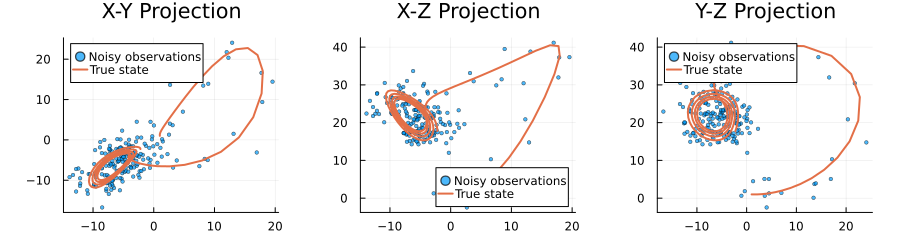

In [5]:
# Extract first samples from datasets
sample_clean = dataset.signal
sample_noisy = dataset.noisy_signal

# Pre-allocate arrays for better performance
n_points = length(sample_clean)
gx, gy, gz = zeros(n_points), zeros(n_points), zeros(n_points)
rx, ry, rz = zeros(n_points), zeros(n_points), zeros(n_points)

# Extract coordinates
for i in 1:n_points
    # Noisy observations
    rx[i], ry[i], rz[i] = sample_noisy[i][1], sample_noisy[i][2], sample_noisy[i][3]
    # True state
    gx[i], gy[i], gz[i] = sample_clean[i][1], sample_clean[i][2], sample_clean[i][3]
end

# Create three projection plots
p1 = scatter(rx, ry, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Y Projection")
plot!(p1, gx, gy, label="True state", linewidth=2)

p2 = scatter(rx, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Z Projection")
plot!(p2, gx, gz, label="True state", linewidth=2)

p3 = scatter(ry, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "Y-Z Projection")
plot!(p3, gy, gz, label="True state", linewidth=2)

# Combine plots with improved layout
plot(p1, p2, p3, size=(900, 250), layout=(1,3), margin=5Plots.mm)

The plots above visualize our noisy Lorenz system dataset from three different perspectives. We can clearly see how the noise (represented by the scattered points) obscures the true underlying dynamics (shown by the solid lines). The Lorenz system's characteristic butterfly-shaped attractor is visible in these projections, though the noisy observations make it challenging to discern the exact trajectory. This visualization highlights the challenge our neural network will face: it must learn to filter out the Gaussian noise (with variance 2.0) and recover the true state of the system at each time step. The X-Y, X-Z, and Y-Z projections each provide a different view of the same 3D dynamical system, helping us understand the full complexity of the dataset.


## Bayesian Inference meets Neural Networks

Our objective is to compute the marginal posterior distribution of the latent (hidden) state $x_k$ at each time step $k$, considering the history of measurements up to that time step:

$$p(x_k | y_{1:k}).$$

The above expression represents the probability distribution of the latent state $x_k$ given the measurements $y_{1:k}$ up to time step $k$. The hidden dynamics of the Lorenz system exhibit nonlinearities and hence cannot be solved in the closed form.
One manner of solving this problem is by introducing a neural network to approximate the transition matrix of the Lorenz system. 

$$\begin{aligned}
A_{k-1}=NN(y_{k-1}) \\
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}x_{k-1}, Q) \\
p(y_k | x_k)=\mathcal{N}(y_k | Bx_k, R)
\end{aligned}$$

where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.
$B$ denote distortion or measurment matrix. $Q$ and $R$ are covariance matrices. 

## Define the Neural Network

We'll define a neural network using Flux.jl to approximate the transition matrix of the Lorenz system. The neural network will take the observation vector as input and output a transformation matrix that predicts the next state. This approach allows us to capture the nonlinear dynamics of the system while maintaining a tractable inference framework.

For demonstration purposes, we'll use a relatively simple neural network architecture - a single Dense layer. 
However, this approach can be extended to more complex architectures such as deeper networks, convolutional 
networks, or recurrent networks, depending on the complexity of the system dynamics you're trying to model.
The key idea is that the neural network learns to predict the transition dynamics of the system based on 
observations, which can then be integrated into our probabilistic state-space model.


In [6]:
function make_neural_network(rng = StableRNG(1234))
    model = Dense(3 => 3)

    # Initialize the weights and biases of the neural network
    flat, rebuild = Flux.destructure(model)

    # We use a fixed random seed for reproducibility
    rand!(rng, flat)

    # Return the neural network with fixed weights and biases
    return rebuild(flat)
end

make_neural_network (generic function with 2 methods)

## Probabilistic Model Specification

Now we'll define our probabilistic state-space model using RxInfer.jl. This model will incorporate the neural network's predictions of the transition matrices. The model consists of two main components: the state transition equation, which uses our neural network to predict how the state evolves, and the observation equation, which relates the hidden state to the measurements. By combining these components, we create a framework that can handle the nonlinear dynamics of the Lorenz system while maintaining computational tractability.


In [7]:
@model function ssm(y, As, Q, B, R)
    
    x_prior_mean = ones(Float32, 3)
    x_prior_cov  = Matrix(Diagonal(ones(Float32, 3)))
    
    x[1] ~ MvNormal(mean = x_prior_mean, cov = x_prior_cov)
    y[1] ~ MvNormal(mean = B * x[1], cov = R)
    
    for i in 2:length(y)
        x[i] ~ MvNormal(mean = As[i - 1] * x[i - 1], cov = Q) 
        y[i] ~ MvNormal(mean = B * x[i], cov = R)
    end
end

We set distortion matrix $B$ and the covariance matrices $Q$ and $R$ as identity matrix. We assume that the observation noise is Gaussian with variance 2.0.

In [8]:
Q = diageye(Float32, 3)
B = diageye(Float32, 3)
R = variance * diageye(Float32, 3)
;

Before proceeding with inference, we need to build a function that extracts the transition matrix $A$ from the neural network's output. These matrices will be fixed during the inference process.


In [9]:
function get_matrices_from_neural_network(data, neural_network)
    dd = hcat(data...)
    As = neural_network(dd)
    return map(c -> Matrix(Diagonal(c)), eachcol(As))
end

get_matrices_from_neural_network (generic function with 1 method)

### Un-trained network

Before network training, we show the inference results for the hidden states:

In this section, we'll demonstrate how our model performs with an untrained neural network.
This will serve as a baseline to compare against after training.
We expect the inference results to be poor since the untrained network generates
random transition matrices that don't capture the true dynamics of the system.
The plots below will visualize the true states, noisy observations, and the inferred states
for each of the three coordinates in our state space model.

In [10]:
# Performance on an instance from the testset before training
untrained_neural_network = make_neural_network()
untrained_transition_matrices = get_matrices_from_neural_network(dataset.noisy_signal, untrained_neural_network)

untrained_result = infer(
    model = ssm(As = untrained_transition_matrices, Q = Q, B = B, R = R), 
    data  = (y = dataset.noisy_signal, ), 
    returnvars = (x = KeepLast(), )
)


Inference results:
  Posteriors       | available for (x)


In [11]:
# A helper function for plotting
function plot_coordinate(result, i)
    p = scatter(getindex.(dataset.noisy_signal, i), label="Observations", alpha=0.7, markersize=2, title = "First coordinate")
    plot!(getindex.(dataset.signal, i), label="True states", linewidth=2)
    plot!(getindex.(mean.(result.posteriors[:x]), i), ribbon=sqrt.(getindex.(var.(result.posteriors[:x]), i)), label="Inferred states", linewidth=2)
    return p
end

function plot_coordinates(result)
    p1 = plot_coordinate(result, 1)
    p2 = plot_coordinate(result, 2)
    p3 = plot_coordinate(result, 3)
    return plot(p1, p2, p3, size = (1000, 600), layout = (3, 1), legend=:bottomleft)
end

plot_coordinates (generic function with 1 method)

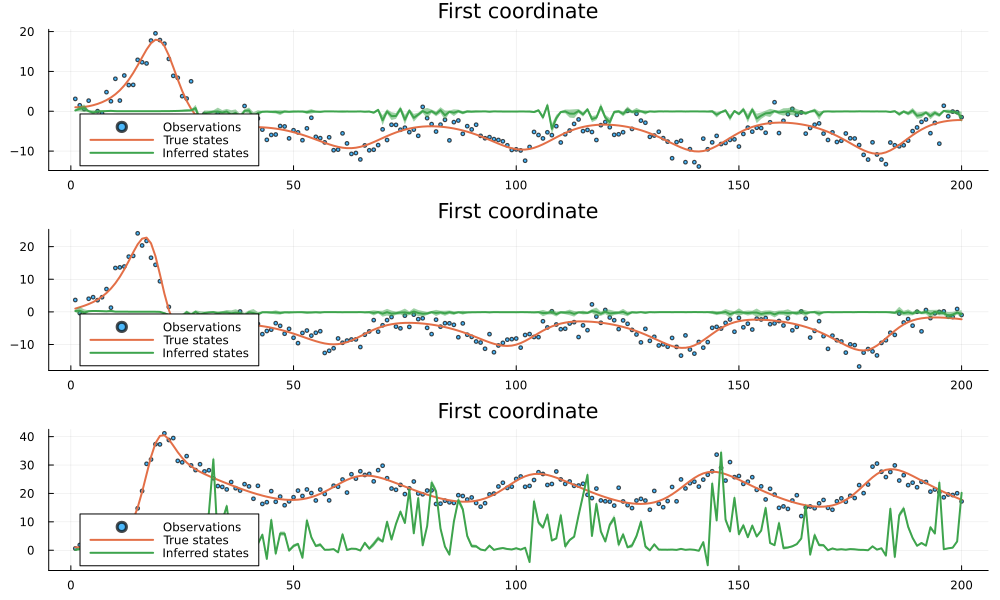

In [12]:
plot_coordinates(untrained_result)

As we can see from the plots above, the inference results with an untrained neural network are essentially nonsense. The inferred states (green lines) fail to track the true states (orange lines) and instead produce arbitrary values with large uncertainty bands. This is expected since the untrained neural network generates random transition matrices that don't capture the actual dynamics of the system. The large discrepancy between the inferred and true states demonstrates why proper training of the neural network is necessary to achieve meaningful results.


### Training the network

In this part, we use the Free Energy as the objective function to optimize the weights of our neural network. 
Free Energy is a variational inference objective that balances model fit with complexity.
By minimizing Free Energy, we encourage the neural network to learn transition matrices that:
1. Accurately predict the next state given the current state (reducing prediction error)
2. Maintain appropriate uncertainty in the predictions
3. Capture the underlying dynamics of the system without overfitting to noise

The optimization process will iteratively update the neural network weights using gradient descent,
with the goal of finding transition matrices that best explain our observed data.

In [13]:
# free energy objective to be optimized during training
function make_fe_tot_est(rebuild, data; Q = Q, B = B, R = R)
    function fe_tot_est(v)
        nn = rebuild(v)
        result = infer(
            model = ssm(As = get_matrices_from_neural_network(data, nn), Q = Q, B = B, R = R), 
            data  = (y = data, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true,
            session = nothing
        )
        return result.free_energy[end]
    end
end

make_fe_tot_est (generic function with 1 method)

In [14]:
function train!(neural_network, data; num_epochs = 500)
    rule = Flux.Optimise.Adam()
    state = Flux.Optimise.setup(rule, neural_network)

    x, rebuild = Flux.destructure(neural_network)
    fe_tot_est_ = make_fe_tot_est(rebuild, data)

    run_epochs!(rebuild, fe_tot_est_, state, neural_network; num_epochs = num_epochs)
end

function run_epochs!(rebuild::F, fe_tot_est::I, state::S, neural_network::N; num_epochs::Int = 100) where {F, I, S, N}
    print_each = num_epochs ÷ 10
    start_time = time()
    for epoch in 1:num_epochs
        flat, _ = Flux.destructure(neural_network)
        if epoch % print_each == 0
            current_value = fe_tot_est(flat)
            elapsed = time() - start_time
            remaining = elapsed / epoch * (num_epochs - epoch)
            println("Epoch $epoch/$num_epochs: Free Energy = $current_value, ETA: $(round(remaining; digits=1)) seconds")
        end
        grads = ForwardDiff.gradient(fe_tot_est, flat);
        Flux.update!(state, neural_network, rebuild(grads))
    end
    # Calculate and print total training time
    total_time = time() - start_time
    println("Finished in $(round(total_time; digits=1)) seconds")
end

run_epochs! (generic function with 1 method)

Now that we have defined our neural network architecture, dataset, and training functions, we can proceed with the training process. We'll train the neural network to learn the underlying dynamics of our state-space model from noisy observations. The training will optimize the free energy objective function using the Adam optimizer over multiple epochs. This process will allow the neural network to capture the non-linear relationships in the data, enabling more accurate state inference compared to traditional linear models. The following cell executes the training with 2000 epochs, which should provide sufficient iterations for convergence.


In [ ]:
trained_neural_network = make_neural_network()

train!(trained_neural_network, dataset.noisy_signal; num_epochs = 2000)

Epoch 200/2000: Free Energy = 22551.90055218744, ETA: 167.9 seconds
Epoch 400/2000: Free Energy = 15266.038012175379, ETA: 99.1 seconds
Epoch 600/2000: Free Energy = 1976.811873287412, ETA: 72.0 seconds
Epoch 800/2000: Free Energy = 1528.4575790320473, ETA: 55.1 seconds
Epoch 1000/2000: Free Energy = 1510.1479994212232, ETA: 43.0 seconds


Now let's analyze the results of our neural network training. We'll visualize how well our trained model can infer the true states from noisy observations. The plots below will show the original noisy observations, the true underlying states, and our model's inferred states with confidence intervals. This comparison will help us evaluate the effectiveness of our neural network-based approach in capturing the non-linear dynamics of the system and filtering out noise.


In [ ]:
trained_transition_matrices = get_matrices_from_neural_network(dataset.noisy_signal, trained_neural_network)

trained_result = infer(
    model = ssm(As = trained_transition_matrices, Q = Q, B = B, R = R), 
    data  = (y = dataset.noisy_signal, ), 
    returnvars = (x = KeepLast(), )
)

plot_coordinates(trained_result)

The results demonstrate the effectiveness of our neural network-based state-space model approach. Despite the significant noise present in the observations (shown as scattered points), our model successfully identifies the underlying hidden signal (shown by the inferred states line). The close alignment between the inferred states and the true states across all three coordinates indicates that the trained neural network has effectively learned the non-linear dynamics of the system. The narrow confidence bands (shown as ribbons) around the inferred states further suggest high confidence in the predictions. This example illustrates how combining neural networks with probabilistic state-space models can provide robust inference in scenarios with complex dynamics and noisy observations.


In [ ]:
ix, iy, iz = zeros(n_points), zeros(n_points), zeros(n_points)

inferred_mean = mean.(trained_result.posteriors[:x])

# Extract coordinates
for i in 1:n_points
    # Inferred mean
    ix[i], iy[i], iz[i] = inferred_mean[i][1], inferred_mean[i][2], inferred_mean[i][3]
end

# Create three projection plots
p1 = scatter(rx, ry, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Y Projection")
plot!(p1, gx, gy, label="True state", linewidth=2)
plot!(p1, ix, iy, label="Inferred Mean", linewidth=2)

p2 = scatter(rx, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Z Projection")
plot!(p2, gx, gz, label="True state", linewidth=2)
plot!(p2, ix, iz, label="Inferred Mean", linewidth=2)

p3 = scatter(ry, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "Y-Z Projection")
plot!(p3, gy, gz, label="True state", linewidth=2)
plot!(p3, iy, iz, label="Inferred Mean", linewidth=2)

# Combine plots with improved layout
plot(p1, p2, p3, size=(900, 250), layout=(1,3), margin=5Plots.mm)